In [1]:
import pandas as pd
import numpy as np
import pickle
import os



def save_pkl(data, path):
    with open(path, 'wb') as ww:
        pickle.dump(data, ww)
        
def load_pkl(path):
    with open(path, 'rb') as rr:
        data = pickle.load(rr)
    return data



def get_station_ids(geost, label_index):
    
    '''args : geost, label_index'''
    
    station_ids = list(set(geost[geost['label']==label_index]['station_id']))
    
    print(f"we get {len(station_ids)} station ids which in {label_index} label index area.")
    
    return station_ids


def get_area_df(dataframe, station_ids):
    
    '''args : dataframe, station_ids'''
    
    indices_tmp = []

    for i in range(len(station_ids)):
        index_tmp = list(dataframe[dataframe['start_station_id']==station_ids[i]]['start_station_id'])
        indices_tmp.append(index_tmp)
    
    indices_area = set()

    for i in range(len(indices_tmp)):
        for j in indices_tmp[i]:
            indices_area.add(j)
                   
                
    df_area = dataframe[dataframe['start_station_id'].isin(indices_area)]
                   
    df_area.reset_index(inplace=True, drop=True)
                   
    return df_area


def get_covid_split(dataframe):
    
    '''args : dataframe'''
    
    bc_statement = "start_rental_date_time >= '2019-01-01' and start_rental_date_time < '2019-09-01'"
    ac_statement = "start_rental_date_time >= '2020-01-01' and start_rental_date_time < '2020-09-01'"
    
    df_bc = dataframe.query(bc_statement).drop(columns='Unnamed: 0')
    df_ac = dataframe.query(ac_statement).drop(columns='Unnamed: 0')
    
    return df_bc, df_ac


def make_co_mat(dataframe, label_index, covid, file_name):
    
    '''args : dataframe, label_index, covid, file_name'''
    
    df_matrix = dataframe[['end_station_id', 'start_station_id']]
    co_matrix = pd.crosstab(df_matrix['start_station_id'], df_matrix['end_station_id'])
    
    co_matrix.to_csv(f"co_mat_{file_name}_{label_index}_{covid}.csv")
    
    return co_matrix



def make_node_edge(label_index, covid, file_name):
    
    '''args : label_index, covid, file_name'''
    
    
    co_matrix = pd.read_csv(f"co_mat_{file_name}_{label_index}_{covid}.csv")
        
        
    def get_edge(from_, to_):

        row_boolean = co_matrix['start_station_id'] == from_

        value = co_matrix[row_boolean][str(int(to_))].values[0]

        return value
    
    
    nodes = [int(id_) for id_ in co_matrix['start_station_id']]

    edges = [[from_, to_, get_edge(from_, to_)] for from_ in nodes for to_ in nodes]

    node_and_edge = {'nodes' : nodes, 'edges' : edges}
    
    return node_and_edge


def make_edge_weight(node_and_edge):
    
    '''args : node_and_edge'''
    
    df = pd.DataFrame(node_and_edge['edges'], columns =['from', 'to', 'value'], dtype=int)
    df = df.rename(columns = {'from' : 'source', 'to' : 'target'})
    
    edges = df[['source','target']].values.tolist()
    weights = [float(l) for l in df.value.values.tolist()]
    
    return edges, weights


def make_network(edges, weights):
    
    '''args : edges, weights'''
    
    import community as community_louvain
    import matplotlib.cm as cm
    import matplotlib.pyplot as plt
    import networkx as nx
    
    G = nx.Graph(directed=True)
    G.add_edges_from(edges)
    
    for cnt, a in enumerate(G.edges(data=True)):
        G.edges[(a[0], a[1])]['weight'] = weights[cnt]
        
    # 참고 : https://lsjsj92.tistory.com/587
    fig = plt.figure(figsize=(20,10))

    # compute the best partition
    partition = community_louvain.best_partition(G)

    # draw the graph
    pos = nx.spring_layout(G)
    
    # color the nodes according to their partition
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                           cmap=cmap, node_color=list(partition.values()))
    
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    
    plt.show()
    
    return partition


def community_detection(geost, dataframe, area_label, file_name):
    
    '''
    [args]
    
    geost : geostations.pkl 파일
    dataframe : 커뮤니티 디텍션 할 대상 파일    예) london_10m.csv (CASE4 - duration 10분 이내 대여 건수 대상 CSV 데이터셋)
    area_label : 집중할 지역의 index    예) 11 혹은 25
    file_name : dataframe의 파일명(중간 결과들 저장, 불러올 때 쉽게 인식하기 위해 파일명을 가져오게끔.. 함..)
    
    '''
    
    # get station ids of indicated area according to area label
    print("step 1 : get_station_ids")
    station_ids = get_station_ids(geost, area_label)
    
    # make dataframe of area
    print("step 2 : get_area_df")
    df_area = get_area_df(dataframe, station_ids)
    
    # make dataframe before and after covid
    print("step 3 : get_covid_split")
    df_area_bc, df_area_ac = get_covid_split(df_area)
    
    print("step 4 : make_co_mat")
    co_mat_bc = make_co_mat(df_area_bc, area_label, 'bc', file_name)
    co_mat_ac = make_co_mat(df_area_ac, area_label, 'ac', file_name)
    
    print("step 5 : make node and edge")
    node_and_edge_bc = make_node_edge(area_label, 'bc', file_name)
    node_and_edge_ac = make_node_edge(area_label, 'ac', file_name)
    
    print("step 6 : make edges and weights for graph")
    edges_bc, weights_bc = make_edge_weight(node_and_edge_bc)
    edges_ac, weights_ac = make_edge_weight(node_and_edge_ac)
    
    print("step 7 : calculate partitions(classes) for community detection")
    partition_bc = make_network(edges_bc, weights_bc)
    partition_ac = make_network(edges_ac, weights_ac)
    
    # node_per_class
    num_partitions_bc = len(set(partition_bc.values()))
    num_partitions_ac = len(set(partition_ac.values()))
    
    node_per_class_bc = {i : [] for i in range(num_partitions_bc)}
    node_per_class_ac = {i : [] for i in range(num_partitions_ac)}
    
    print("step 8 : make node_per_class for bc and ac")
    for i in node_and_edge_bc['nodes']:
        for cls in range(num_partitions_bc):
            if partition_bc[int(i)] == cls:
                node_per_class_bc[cls].append(i)
    
    for i in node_and_edge_ac['nodes']:
        for cls in range(num_partitions_ac):
            if partition_ac[int(i)] == cls:
                node_per_class_ac[cls].append(i)
        
    
    return node_per_class_bc, node_per_class_ac
    

step 1 : get_station_ids
we get 60 station ids which in 11 label index area.
step 2 : get_area_df
step 3 : get_covid_split
step 4 : make_co_mat
step 5 : make node and edge
step 6 : make edges and weights for graph
step 7 : calculate partitions(classes) for community detection


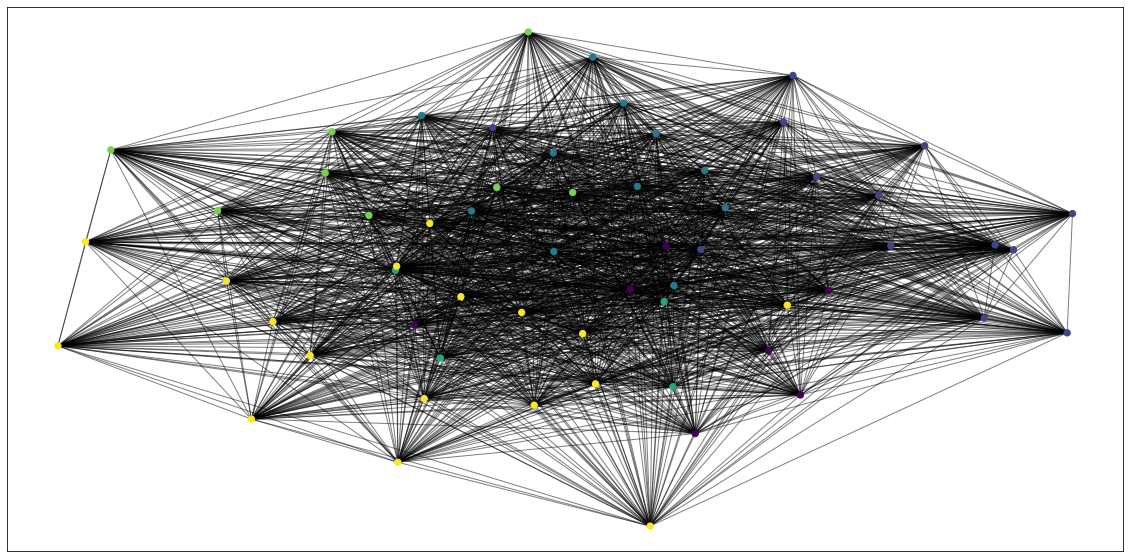

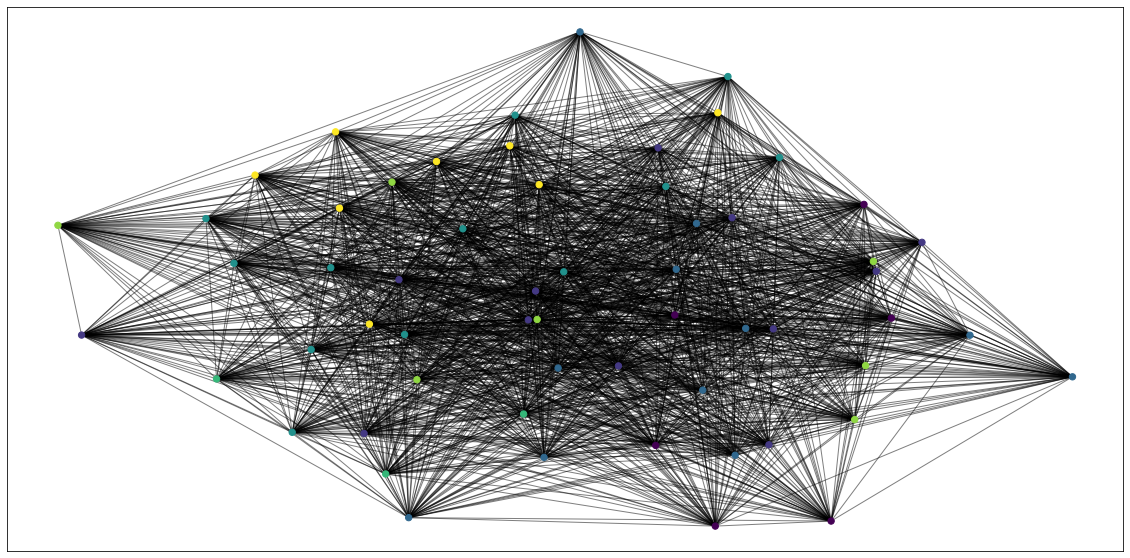

step 8 : make node_per_class for bc and ac


In [2]:
geost = load_pkl("geostations.pkl")
dataframe = pd.read_csv('london_10m.csv')
area_label = 11
file_name = 'london_10m.csv'


node_per_class_bc_11, node_per_class_ac_11 = community_detection(geost, dataframe, area_label, file_name)